In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
retail = pd.read_csv("OnlineRetail1.csv",sep=",",encoding="ISO-8859-1",header=0)
retail

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,09-12-2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,09-12-2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,09-12-2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,09-12-2011 12:50,4.15,12680.0,France


In [3]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


# Null Value Identification and Treatment

In [4]:
# Number of null values in the dataset
retail.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
# Percentage of null values in the dataset
round((retail.isnull().sum()/len(retail))*100,2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [6]:
retail.shape

(541909, 8)

In [7]:
# Clean the data from null values

retail_df = retail.dropna()
retail_df.shape

(406829, 8)

OBJECTIVE: For a particular customer, what is the total amount spent, how many purchased - frequency, recency - how long back was the last purchase

In [8]:
retail_df["Amount"] = retail_df["Quantity"]*retail_df["UnitPrice"]

C:\Users\alkap\AppData\Local\Temp\ipykernel_10576\1688087608.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retail_df["Amount"] = retail_df["Quantity"]*retail_df["UnitPrice"]


In [9]:
retail_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,09-12-2011 12:50,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,09-12-2011 12:50,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,09-12-2011 12:50,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,09-12-2011 12:50,4.15,12680.0,France,16.60


In [10]:
grouped_df1 = retail_df.groupby("CustomerID")["Amount"].sum()
grouped_df1 = grouped_df1.reset_index()
grouped_df1

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40
...,...,...
4367,18280.0,180.60
4368,18281.0,80.82
4369,18282.0,176.60
4370,18283.0,2094.88


In [11]:
# What is the frequency of purchases - count of invoices

frequency = retail_df.groupby("CustomerID")["InvoiceNo"].count()
frequency = frequency.reset_index()
frequency.columns = ["CustomerID","Frequency"]
frequency

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17
...,...,...
4367,18280.0,10
4368,18281.0,7
4369,18282.0,13
4370,18283.0,756


In [12]:
grouped_df = pd.merge(grouped_df1,frequency,on="CustomerID",how="inner")
grouped_df

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17
...,...,...,...
4367,18280.0,180.60,10
4368,18281.0,80.82,7
4369,18282.0,176.60,13
4370,18283.0,2094.88,756


In [13]:
# Recency

In [14]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
 8   Amount       406829 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 31.0+ MB


In [15]:
retail_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,09-12-2011 12:50,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,09-12-2011 12:50,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,09-12-2011 12:50,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,09-12-2011 12:50,4.15,12680.0,France,16.60


In [16]:
retail_df["InvoiceDate"] = pd.to_datetime(retail_df["InvoiceDate"],format = "%d-%m-%Y %H:%M")

C:\Users\alkap\AppData\Local\Temp\ipykernel_10576\4148960441.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retail_df["InvoiceDate"] = pd.to_datetime(retail_df["InvoiceDate"],format = "%d-%m-%Y %H:%M")


In [17]:
retail_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


In [18]:
max_date = max(retail_df["InvoiceDate"])

In [19]:
max_date

Timestamp('2011-12-09 12:50:00')

In [20]:
retail_df["diff"] = max_date - retail_df["InvoiceDate"]

C:\Users\alkap\AppData\Local\Temp\ipykernel_10576\559773002.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retail_df["diff"] = max_date - retail_df["InvoiceDate"]


In [21]:
retail_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20,0 days 00:00:00
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,0 days 00:00:00
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,0 days 00:00:00
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,0 days 00:00:00


In [22]:
last_purchase = retail_df.groupby(["CustomerID"])["diff"].min().reset_index()
last_purchase


,CustomerID,diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00
...,...,...
4367,18280.0,277 days 02:58:00
4368,18281.0,180 days 01:57:00
4369,18282.0,7 days 01:07:00
4370,18283.0,3 days 00:48:00


In [45]:
grouped_df_final = pd.merge(grouped_df,last_purchase,on="CustomerID",how ="inner")
grouped_df_final

,CustomerID,Amount,Frequency,diff
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00
...,...,...,...,...
4367,18280.0,180.60,10,277 days 02:58:00
4368,18281.0,80.82,7,180 days 01:57:00
4369,18282.0,176.60,13,7 days 01:07:00
4370,18283.0,2094.88,756,3 days 00:48:00


In [46]:
grouped_df_final.columns = ["CustomerID","Amount","Frequency","Recency"]

In [47]:
grouped_df_final

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00
...,...,...,...,...
4367,18280.0,180.60,10,277 days 02:58:00
4368,18281.0,80.82,7,180 days 01:57:00
4369,18282.0,176.60,13,7 days 01:07:00
4370,18283.0,2094.88,756,3 days 00:48:00


In [48]:
grouped_df_final["Recency"] = grouped_df_final["Recency"].dt.days
grouped_df_final

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309
...,...,...,...,...
4367,18280.0,180.60,10,277
4368,18281.0,80.82,7,180
4369,18282.0,176.60,13,7
4370,18283.0,2094.88,756,3


# Outlier Treatment

{'whiskers': [<matplotlib.lines.Line2D at 0x27f916ceb10>,
 'caps': [<matplotlib.lines.Line2D at 0x27f96750110>,
 'boxes': [<matplotlib.lines.Line2D at 0x27f92e30e90>],
 'medians': [<matplotlib.lines.Line2D at 0x27f96751550>],
 'fliers': [<matplotlib.lines.Line2D at 0x27f96751d50>],
 'means': []}

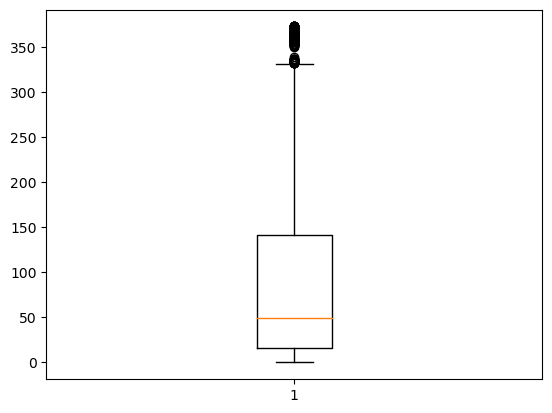

In [49]:
plt.boxplot(grouped_df_final["Recency"])

In [50]:
Q1 = grouped_df_final["Amount"].quantile(0.05)
Q3 = grouped_df_final["Amount"].quantile(0.95)
IQR = Q3-Q1
grouped_df_final = grouped_df_final[(grouped_df_final["Amount"]>= Q1 - 1.5*IQR) & (grouped_df_final["Amount"]<=Q3+1.5*IQR)]

Q1 = grouped_df_final["Recency"].quantile(0.05)
Q3 = grouped_df_final["Recency"].quantile(0.95)
IQR = Q3-Q1
grouped_df_final = grouped_df_final[(grouped_df_final["Recency"]>=Q1 - 1.5*IQR) & (grouped_df_final["Recency"]<=Q3+1.5*IQR)]

Q1 = grouped_df_final["Frequency"].quantile(0.05)
Q3 = grouped_df_final["Frequency"].quantile(0.95)
IQR = Q3-Q1
grouped_df_final = grouped_df_final[(grouped_df_final["Frequency"]>= Q1 - 1.5*IQR) & (grouped_df_final["Frequency"]<=Q3+1.5*IQR)]


In [51]:
grouped_df_final.shape

(4293, 4)

In [52]:
rfm_df = grouped_df_final[["Amount","Frequency","Recency"]]

In [53]:
rfm_df

,Amount,Frequency,Recency
0,0.00,2,325
1,4310.00,182,1
2,1797.24,31,74
3,1757.55,73,18
4,334.40,17,309
...,...,...,...
4366,173.90,9,73
4367,180.60,10,277
4368,80.82,7,180
4369,176.60,13,7


In [54]:
scaler  = StandardScaler()

rfm_scaled = scaler.fit_transform(rfm_df)

rfm_scaled


array([[-0.72373821, -0.75288754,  2.30161144],
       [ 1.73161722,  1.04246665, -0.90646561],
       [ 0.30012791, -0.46363604, -0.18365813],
       ...,
       [-0.67769602, -0.70301659,  0.86589794],
       [-0.6231313 , -0.64317145, -0.84705678],
       [ 0.32293822, -0.07464263, -0.50050524]])

In [55]:
rfm_df_scaled = pd.DataFrame(rfm_scaled)
rfm_df_scaled

,0,1,2
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188
...,...,...,...
4288,-0.624669,-0.683068,-0.193560
4289,-0.620853,-0.673094,1.826341
4290,-0.677696,-0.703017,0.865898
4291,-0.623131,-0.643171,-0.847057


In [56]:
rfm_df_scaled.columns = ["Amount","Frequency","Recency"]

In [57]:
rfm_df_scaled

,Amount,Frequency,Recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188
...,...,...,...
4288,-0.624669,-0.683068,-0.193560
4289,-0.620853,-0.673094,1.826341
4290,-0.677696,-0.703017,0.865898
4291,-0.623131,-0.643171,-0.847057


# K means

In [58]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(rfm_df_scaled)

C:\Users\alkap\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=4)

In [59]:
kmeans.labels_

array([3, 1, 0, ..., 3, 0, 0])

In [60]:
# How to find the optimal number of clusters?

In [61]:
ss = []
num_clusters = [2,3,4,5,6,7,8,9,10]

for n in num_clusters:
    kmeans = KMeans(n_clusters = n)
    kmeans.fit(rfm_df_scaled)
    ss.append(kmeans.inertia_)

C:\Users\alkap\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\alkap\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\alkap\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\alkap\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

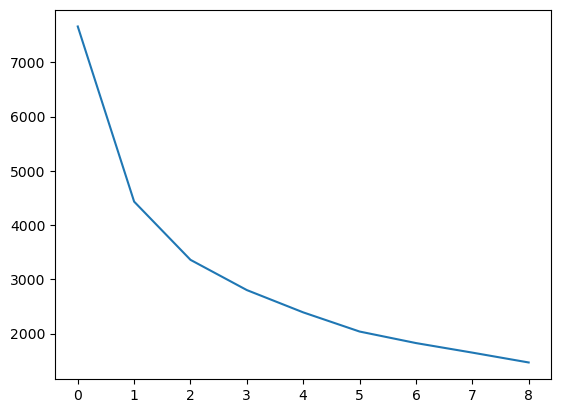

In [62]:
plt.plot(ss)

In [63]:

num_clusters = [2,3,4,5,6,7,8,9,10]

for n in num_clusters:
    kmeans = KMeans(n_clusters = n)
    kmeans.fit(rfm_df_scaled)
    cluster_labels = kmeans.labels_
    
    silhouette = silhouette_score(rfm_df_scaled,cluster_labels)
    print("For number of clusters = {}, the S score is {}".format(n,silhouette))

C:\Users\alkap\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For number of clusters = 2, the S score is 0.5415858652525395


C:\Users\alkap\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For number of clusters = 3, the S score is 0.5084896296141937


C:\Users\alkap\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For number of clusters = 4, the S score is 0.47943362518683813


C:\Users\alkap\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For number of clusters = 5, the S score is 0.4658595948596644


C:\Users\alkap\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For number of clusters = 6, the S score is 0.41752310128909054


C:\Users\alkap\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For number of clusters = 7, the S score is 0.41569122856918544


C:\Users\alkap\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For number of clusters = 8, the S score is 0.4093799889419855


C:\Users\alkap\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For number of clusters = 9, the S score is 0.41446287444794255


C:\Users\alkap\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For number of clusters = 10, the S score is 0.3809015334078096


In [64]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(rfm_df_scaled)

C:\Users\alkap\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3)

In [65]:
kmeans.labels_

array([2, 1, 0, ..., 2, 0, 0])

In [66]:
grouped_df_final["Cluster_ID"] = kmeans.labels_

In [67]:
grouped_df_final

,CustomerID,Amount,Frequency,Recency,Cluster_ID
0,12346.0,0.00,2,325,2
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,2
...,...,...,...,...,...
4366,18278.0,173.90,9,73,0
4367,18280.0,180.60,10,277,2
4368,18281.0,80.82,7,180,2
4369,18282.0,176.60,13,7,0


In [68]:
grouped_df_final["Cluster_ID"].unique()

array([2, 1, 0])

<Axes: xlabel='Cluster_ID', ylabel='Amount'>

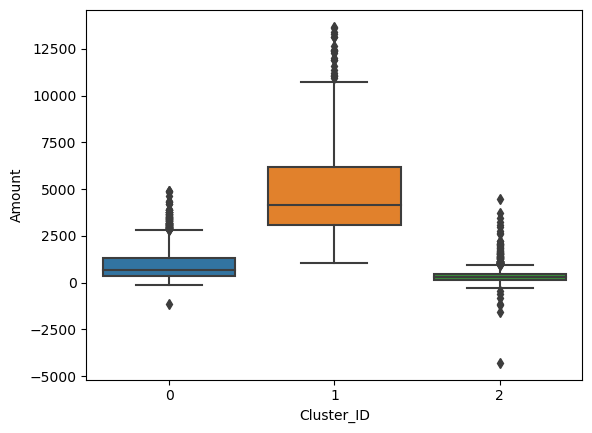

In [69]:
# Analyzing clusters
sns.boxplot(x="Cluster_ID",y="Amount",data = grouped_df_final)

# Hierarchical Clustering

In [70]:
rfm_df_scaled

,Amount,Frequency,Recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188
...,...,...,...
4288,-0.624669,-0.683068,-0.193560
4289,-0.620853,-0.673094,1.826341
4290,-0.677696,-0.703017,0.865898
4291,-0.623131,-0.643171,-0.847057


In [71]:
grouped_df_final

,CustomerID,Amount,Frequency,Recency,Cluster_ID
0,12346.0,0.00,2,325,2
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,2
...,...,...,...,...,...
4366,18278.0,173.90,9,73,0
4367,18280.0,180.60,10,277,2
4368,18281.0,80.82,7,180,2
4369,18282.0,176.60,13,7,0


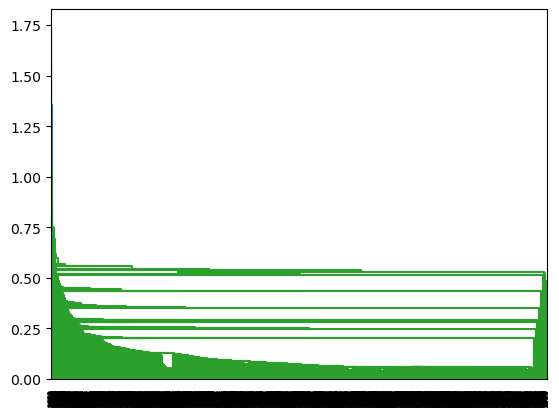

In [72]:
mergings = linkage(rfm_df_scaled,method="single",metric="euclidean")
dendrogram(mergings)
plt.show()

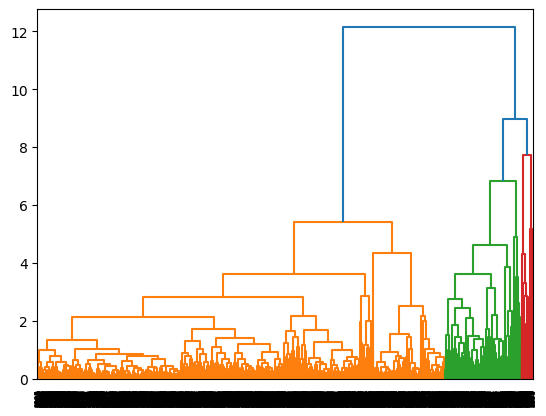

In [73]:
mergings = linkage(rfm_df_scaled,method="complete",metric="euclidean")
dendrogram(mergings)
plt.show()

In [76]:
cluster_labels = cut_tree(mergings,n_clusters=3).reshape(-1,)

In [77]:
cluster_labels

array([0, 1, 0, ..., 0, 0, 0])

In [78]:
grouped_df_final["Cluster_Hier"] = cluster_labels

In [79]:
grouped_df_final

,CustomerID,Amount,Frequency,Recency,Cluster_ID,Cluster_Hier
0,12346.0,0.00,2,325,2,0
1,12347.0,4310.00,182,1,1,1
2,12348.0,1797.24,31,74,0,0
3,12349.0,1757.55,73,18,0,0
4,12350.0,334.40,17,309,2,0
...,...,...,...,...,...,...
4366,18278.0,173.90,9,73,0,0
4367,18280.0,180.60,10,277,2,0
4368,18281.0,80.82,7,180,2,0
4369,18282.0,176.60,13,7,0,0


# Cluster Analysis

<Axes: xlabel='Cluster_Hier', ylabel='Amount'>

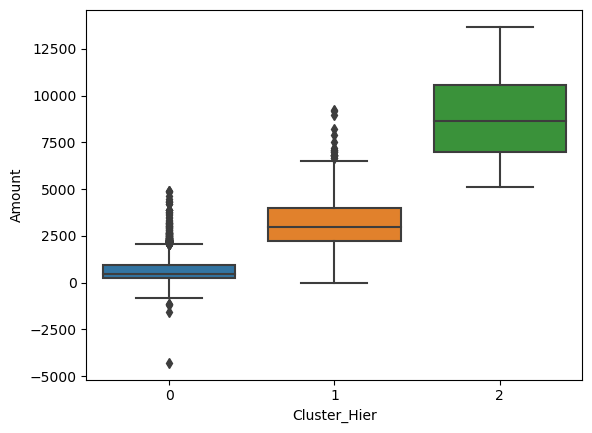

In [81]:
sns.boxplot(x="Cluster_Hier",y="Amount",data = grouped_df_final)

<Axes: xlabel='Cluster_Hier', ylabel='Recency'>

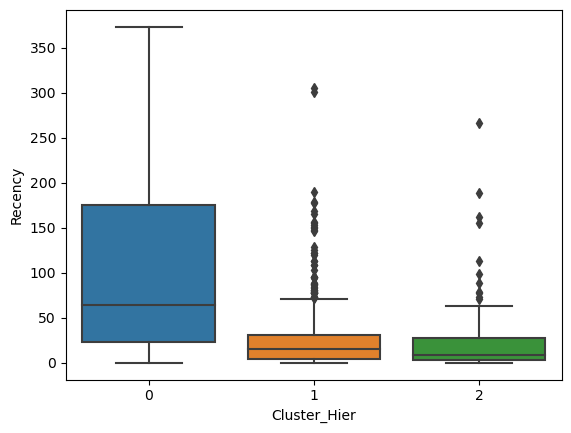

In [82]:
sns.boxplot(x="Cluster_Hier",y="Recency",data = grouped_df_final)